In [1]:
import torch as t
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torch import nn
import torch.nn.functional as F

from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if t.cuda.is_available() else "cpu"

### Data

In [3]:
train_frac = 0.7
val_frac = 0.15
batch_size = 32

In [4]:
class ImageMasksDataset(Dataset):
    def __init__(self, root_dir, transform):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform

        self.image_mask_pairs = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                images = sorted([f for f in os.listdir(folder_path) if f.endswith(".tif") and "mask" not in f])
                for img_file in images:
                    mask_file = img_file.replace(".tif", "_mask.tif")
                    img_path = os.path.join(folder_path, img_file)
                    mask_path = os.path.join(folder_path, mask_file)
                    if os.path.exists(mask_path):
                        self.image_mask_pairs.append((img_path, mask_path))
    
    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            img, mask = self.transform(img), self.transform(mask)

        mask = mask.squeeze(0)
        
        return img, mask.to(t.long)

In [5]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [6]:
image_mask_dataset = ImageMasksDataset(
    root_dir="./data",
    transform=transform,
)

In [7]:
train_size = int(len(image_mask_dataset) * train_frac)
val_size = int(len(image_mask_dataset) * val_frac)
test_size = len(image_mask_dataset) - train_size - val_size

In [8]:
train_set, val_set, test_set = random_split(image_mask_dataset, lengths=[train_size, val_size, test_size])

In [9]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [25]:
for images, masks in tqdm(train_loader):
    images, masks = images.to(device), masks.to(device)

100%|██████████| 86/86 [00:07<00:00, 11.82it/s]


### Model

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Final 1x1 convolution
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Identity()
        )
    
    def upconv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):

        # Encoding
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))

        # Bottlenecking
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Decoding
        dec4 = self.upconv4(bottleneck)
        dec4 = t.cat((enc4, dec4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = t.cat((enc3, dec3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = t.cat((enc2, dec2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = t.cat((enc1, dec1), dim=1)
        dec1 = self.dec1(dec1)

        return self.conv_last(dec1)

### Training

In [16]:
model = UNet(in_channels=3, out_channels=2).to(device)

In [17]:
lr = 1e-03
wd = 1e-03

class_weights = t.tensor([0.2, 0.8]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

In [18]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    total_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model(inputs)
        loss = criterion(logits, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return total_loss / len(train_loader)

def eval(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with t.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [19]:
train_losses = []
val_losses = []
num_epochs = 10

for epoch in range(1, num_epochs+1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = eval(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{num_epochs} | Train loss : {train_loss:.3e} | Val loss : {val_loss:.3e}")

100%|██████████| 19/19 [00:10<00:00,  1.77it/s]


Epoch 1/10 | Train loss : 1.314e-01 | Val loss : 8.864e-02


100%|██████████| 19/19 [00:10<00:00,  1.82it/s]


Epoch 2/10 | Train loss : 6.850e-02 | Val loss : 4.791e-02


100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


Epoch 3/10 | Train loss : 4.385e-02 | Val loss : 4.802e-02


100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


Epoch 4/10 | Train loss : 4.006e-02 | Val loss : 4.308e-02


100%|██████████| 19/19 [00:10<00:00,  1.87it/s]


Epoch 5/10 | Train loss : 3.802e-02 | Val loss : 4.493e-02


100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


Epoch 6/10 | Train loss : 3.764e-02 | Val loss : 4.019e-02


100%|██████████| 19/19 [00:10<00:00,  1.87it/s]


Epoch 7/10 | Train loss : 3.638e-02 | Val loss : 3.804e-02


100%|██████████| 19/19 [00:10<00:00,  1.84it/s]


Epoch 8/10 | Train loss : 3.530e-02 | Val loss : 3.771e-02


100%|██████████| 19/19 [00:10<00:00,  1.88it/s]


Epoch 9/10 | Train loss : 3.531e-02 | Val loss : 3.691e-02


100%|██████████| 19/19 [00:09<00:00,  1.90it/s]

Epoch 10/10 | Train loss : 3.388e-02 | Val loss : 3.601e-02


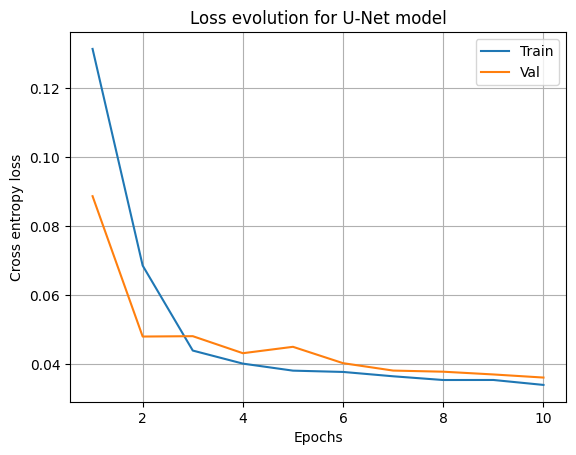

In [77]:
fig = plt.figure()
epochs = list(range(1, num_epochs+1))
plt.plot(epochs, train_losses)
plt.plot(epochs, val_losses)
plt.legend(["Train", "Val"])
plt.xlabel("Epochs")
plt.ylabel("Cross entropy loss")
plt.title("Loss evolution for U-Net model")
plt.grid()
plt.show()

In [20]:
def compare_model_label(idx):

    image = train_set[idx][0].unsqueeze(0).to(device)

    with t.no_grad():
        pred = model(image).squeeze(0).argmax(dim=0)
        
    pred_img = (pred.cpu().detach().numpy() * 255).astype(np.uint8)

    label = train_set[idx][1]
    label_img = (label.cpu().numpy() * 255).astype(np.uint8)

    image = train_set[idx][0]
    image = (image.permute(1,2,0).numpy()*255).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].axis("off")
    axes[0].set_title("Scan")

    axes[1].imshow(label_img, cmap="gray")
    axes[1].axis("off")
    axes[1].set_title("Actual Mask")

    axes[2].imshow(pred_img, cmap="gray")
    axes[2].axis("off")
    axes[2].set_title("Predicted Mask")
    plt.show()

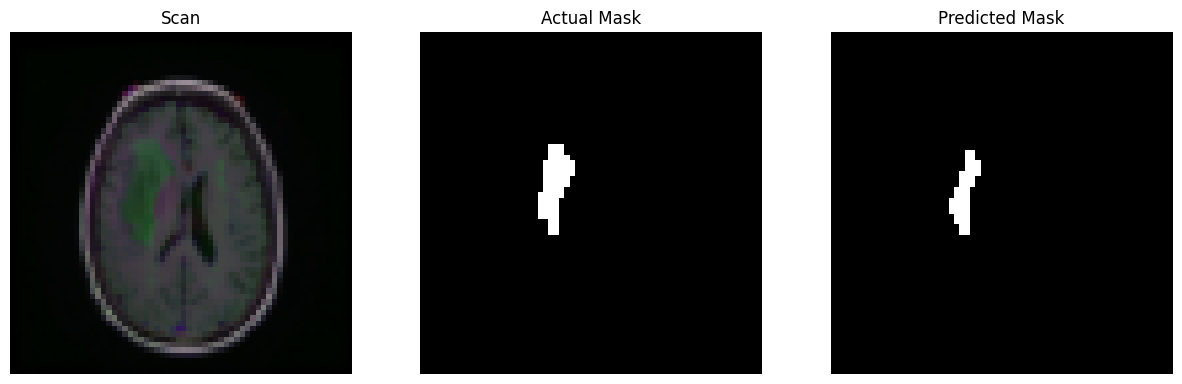

In [73]:
compare_model_label(116)

In [ ]:
# Predict function for random images
def predict(model, img_path):
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)
    logits = model(image).squeeze(0)
    pred = logits.argmax(dim=0)

    # Convert prediction to numpy
    pred = pred.numpy().astype(np.uint8) * 255
    return pred

In [75]:
from datetime import datetime
time = datetime.now().strftime("%d%m%Y-%H%M%S")
t.save(model.state_dict(), f"model_{time}.pth")